In [1]:
import json
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils.convert import from_networkx
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from codecarbon import track_emissions
import numpy as np



In [2]:
json_file = 'elyzee_data/elyzee_train.json'
graph_train_networkx = nx.node_link_graph(json.load(open(json_file)))

json_file = 'elyzee_data/elyzee_test.json'
graph_test_networkx = nx.node_link_graph(json.load(open(json_file)))

In [3]:
num_classes = 7
labels_dict = {
    'lr': 0, 
    'em': 1, 
    'fn': 2, 
    'fi': 3, 
    'ps': 4,
    'multi_affiliations': 5, 
    'indetermined': 6
}
node_id = list(graph_train_networkx.nodes)[0]
num_features = len(graph_train_networkx.nodes[node_id]['features'])

In [4]:
graph_train_torch = from_networkx(graph_train_networkx)
graph_test_torch = from_networkx(graph_test_networkx)
print("Train :",graph_train_torch)
print("Test :",graph_test_torch)

Train : Data(edge_index=[2, 19284], features=[5507, 999], affiliation=[5507], num_nodes=5507)
Test : Data(edge_index=[2, 6402], features=[2222, 999], affiliation=[2222], num_nodes=2222)


In [5]:
graph_train_torch.labels = F.one_hot(torch.tensor(
    [labels_dict[affiliation] for affiliation in graph_train_torch.affiliation]
)).float()
graph_test_torch.labels = F.one_hot(torch.tensor(
    [labels_dict[affiliation] for affiliation in graph_test_torch.affiliation]
)).float()
print("Train labels :", graph_train_torch.labels.shape)
print("Test labels :", graph_test_torch.labels.shape)


Train labels : torch.Size([5507, 7])
Test labels : torch.Size([2222, 7])


# 

In [6]:
# mask qui permet de séparer les données d'entrainement et de validation
train_ratio = 0.8
graph_train_torch.train_mask = torch.randn(graph_train_torch.num_nodes) < train_ratio
graph_train_torch.val_mask = ~graph_train_torch.train_mask

print(f"Train mask : {graph_train_torch.train_mask.shape} | number : {int(graph_train_torch.train_mask.sum())}")
print(f"Val mask : {graph_train_torch.val_mask.shape} | number : {int(graph_train_torch.val_mask.sum())}")

Train mask : torch.Size([5507]) | number : 4317
Val mask : torch.Size([5507]) | number : 1190


# Experience 1 : FCNN

In [7]:
class FCNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(FCNN, self).__init__()
        self.linear1 = nn.Linear(num_features, hidden_channels)
        self.linear2 = nn.Linear(hidden_channels, hidden_channels)
        self.out = nn.Linear(hidden_channels, num_classes)

    def forward(self, x):
        x = self.linear1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.linear2(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.out(x)
        x = F.softmax(x, dim=1)
        return x

In [8]:
@track_emissions()
def train(model, graph_train, graph_test, epoches):
    learning_rate = 0.01
    decay = 1e-4
    optimizer = torch.optim.Adam(model.parameters(),
                                     lr=learning_rate,
                                     weight_decay=decay)
    criterion = torch.nn.CrossEntropyLoss()
    
    list_loss_train = []
    list_loss_val = []
    list_loss_test = []
    
    list_train_acc = []
    list_val_acc = []
    list_test_acc = []
    for epoch in range(epoches):
        model.train()
        optimizer.zero_grad()
        # Forward
        logits_train = model(graph_train.features)
        # Compute loss
        loss_train = criterion(logits_train[graph_train_torch.train_mask], graph_train.labels[graph_train_torch.train_mask]) 
        list_loss_train.append(loss_train.item())
        # Backward
        loss_train.backward()
        optimizer.step()
        
        train_acc = (torch.argmax(logits_train[graph_train_torch.train_mask], dim=1) == torch.argmax(graph_train.labels[graph_train_torch.train_mask], dim=1)).float().mean()
        list_train_acc.append(train_acc.cpu())
        
        loss_val = criterion(logits_train[graph_train_torch.val_mask], graph_train.labels[graph_train_torch.val_mask])
        list_loss_val.append(loss_val.item())
        
        val_acc = (torch.argmax(logits_train[graph_train_torch.val_mask], dim=1) == torch.argmax(graph_train.labels[graph_train_torch.val_mask], dim=1)).float().mean()
        list_val_acc.append(val_acc.cpu())
                

        with torch.no_grad():
            model.eval()
            logits_test = model(graph_test.features)
            loss_test = criterion(logits_test, graph_test.labels)
            list_loss_test.append(loss_test.item())
            test_acc = (torch.argmax(logits_test, dim=1) == torch.argmax(graph_test.labels, dim=1)).float().mean()
            list_test_acc.append(test_acc.cpu())
            
        print('Epoch %d | Loss Train : %.4f | Loss Val : %.4f | Loss Test : %.4f | Train Accuracy : %.4f | Val Accuracy : %.4f | Test Accuracy: %.4f' % (epoch, loss_train.item(), loss_val.item(), loss_test.item(), train_acc, val_acc, test_acc))
                
    return list_loss_train, list_loss_val, list_loss_test, list_train_acc, list_val_acc, list_test_acc

[codecarbon INFO @ 15:03:37] [setup] RAM Tracking...
[codecarbon INFO @ 15:03:37] [setup] GPU Tracking...
[codecarbon INFO @ 15:03:37] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 15:03:37] [setup] CPU Tracking...
[codecarbon WARNING @ 15:03:37] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 15:03:38] We saw that you have a Intel(R) Core(TM) i5-14600KF but we don't know it. Please contact us.
[codecarbon INFO @ 15:03:38] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-14600KF
[codecarbon INFO @ 15:03:38] >>> Tracker's metadata:
[codecarbon INFO @ 15:03:38]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 15:03:38]   Python version: 3.10.11
[codecarbon INFO @ 15:03:38]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 15:03:38]   Available RAM : 31.852 GB
[codecarbon INFO @ 15:03:38]   CPU count: 20
[codecarbon INFO @ 15:03:38]   CPU model: Intel(R) Core(TM) i5-14600KF
[codecarbon INFO @ 15:03:38]   GPU count: 1
[codeca

Epoch 0 | Loss Train : 1.9445 | Loss Val : 1.9444 | Loss Test : 1.9378 | Train Accuracy : 0.1700 | Val Accuracy : 0.1664 | Test Accuracy: 0.1890
Epoch 1 | Loss Train : 1.9332 | Loss Val : 1.9346 | Loss Test : 1.9326 | Train Accuracy : 0.2126 | Val Accuracy : 0.2084 | Test Accuracy: 0.1890
Epoch 2 | Loss Train : 1.9165 | Loss Val : 1.9173 | Loss Test : 1.9243 | Train Accuracy : 0.2089 | Val Accuracy : 0.2092 | Test Accuracy: 0.1890
Epoch 3 | Loss Train : 1.9031 | Loss Val : 1.9069 | Loss Test : 1.9232 | Train Accuracy : 0.2096 | Val Accuracy : 0.2126 | Test Accuracy: 0.1890
Epoch 4 | Loss Train : 1.8998 | Loss Val : 1.9050 | Loss Test : 1.9261 | Train Accuracy : 0.2096 | Val Accuracy : 0.2126 | Test Accuracy: 0.1890
Epoch 5 | Loss Train : 1.8998 | Loss Val : 1.9086 | Loss Test : 1.9266 | Train Accuracy : 0.2096 | Val Accuracy : 0.2126 | Test Accuracy: 0.1890
Epoch 6 | Loss Train : 1.8982 | Loss Val : 1.9073 | Loss Test : 1.9245 | Train Accuracy : 0.2096 | Val Accuracy : 0.2126 | Test Ac

[codecarbon INFO @ 15:03:39] 
Graceful stopping: collecting and writing information.
Please wait a few seconds...
[codecarbon INFO @ 15:03:39] Energy consumed for RAM : 0.000003 kWh. RAM Power : 11.944398880004883 W


Epoch 144 | Loss Train : 1.4497 | Loss Val : 1.8072 | Loss Test : 1.8845 | Train Accuracy : 0.7234 | Val Accuracy : 0.3487 | Test Accuracy: 0.2678
Epoch 145 | Loss Train : 1.4562 | Loss Val : 1.8108 | Loss Test : 1.8845 | Train Accuracy : 0.7176 | Val Accuracy : 0.3412 | Test Accuracy: 0.2682
Epoch 146 | Loss Train : 1.4504 | Loss Val : 1.8141 | Loss Test : 1.8848 | Train Accuracy : 0.7248 | Val Accuracy : 0.3437 | Test Accuracy: 0.2682
Epoch 147 | Loss Train : 1.4469 | Loss Val : 1.8202 | Loss Test : 1.8882 | Train Accuracy : 0.7292 | Val Accuracy : 0.3378 | Test Accuracy: 0.2637
Epoch 148 | Loss Train : 1.4523 | Loss Val : 1.8109 | Loss Test : 1.8888 | Train Accuracy : 0.7239 | Val Accuracy : 0.3454 | Test Accuracy: 0.2637
Epoch 149 | Loss Train : 1.4540 | Loss Val : 1.8036 | Loss Test : 1.8879 | Train Accuracy : 0.7199 | Val Accuracy : 0.3487 | Test Accuracy: 0.2624
Epoch 150 | Loss Train : 1.4484 | Loss Val : 1.7984 | Loss Test : 1.8882 | Train Accuracy : 0.7283 | Val Accuracy : 0.

[codecarbon INFO @ 15:03:39] Energy consumed for all GPUs : 0.000008 kWh. Total GPU Power : 38.23757439398045 W
[codecarbon INFO @ 15:03:39] Energy consumed for all CPUs : 0.000009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:03:39] 0.000020 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:03:39] Done!



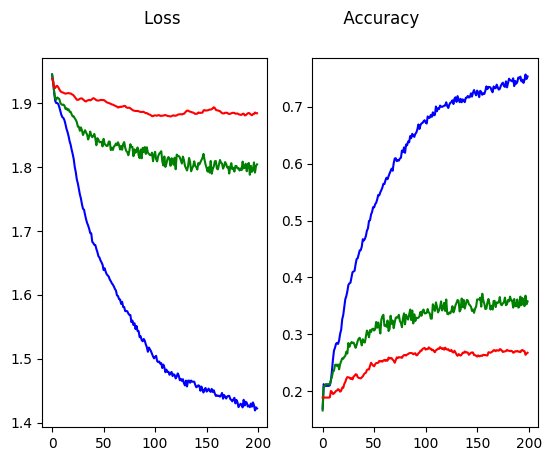

In [9]:
model_fcnn = FCNN(num_features=num_features, hidden_channels=64, num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model_fcnn.to(device)
graph_train_torch = graph_train_torch.to(device)
graph_test_torch = graph_test_torch.to(device)
list_loss_train, list_loss_val, list_loss_test, list_train_acc, list_val_acc, list_test_acc = train(
    model_fcnn,
    graph_train_torch,
    graph_test_torch,
    200
)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Loss                               Accuracy')
ax1.plot(list_loss_train, color='blue')
ax1.plot(list_loss_val, color='green')
ax1.plot(list_loss_test, color='red')
ax2.plot(list_train_acc, color='blue')
ax2.plot(list_val_acc, color='green')
ax2.plot(list_test_acc, color='red')

torch.save(model_fcnn.state_dict(), "model/elyzee_fcnn.pth")

# Experience 2 : GCN

In [27]:
@track_emissions()
def train(model, graph_train, graph_test, epoches):
    learning_rate = 0.01
    decay = 1e-4
    optimizer = torch.optim.Adam(model.parameters(),
                                     lr=learning_rate,
                                     weight_decay=decay)
    criterion = torch.nn.CrossEntropyLoss()
    
    list_loss_train = []
    list_loss_val = []
    list_loss_test = []
    
    list_train_acc = []
    list_val_acc = []
    list_test_acc = []
    for epoch in range(epoches):
        model.train()
        optimizer.zero_grad()
        # Forward
        logits_train = model(graph_train.features, graph_train.edge_index)
        # Compute loss
        loss_train = criterion(logits_train[graph_train_torch.train_mask], graph_train.labels[graph_train_torch.train_mask]) 
        list_loss_train.append(loss_train.item())
        # Backward
        loss_train.backward()
        optimizer.step()
        
        train_acc = (torch.argmax(logits_train[graph_train_torch.train_mask], dim=1) == torch.argmax(graph_train.labels[graph_train_torch.train_mask], dim=1)).float().mean()
        list_train_acc.append(train_acc.cpu())
        
        loss_val = criterion(logits_train[graph_train_torch.val_mask], graph_train.labels[graph_train_torch.val_mask])
        list_loss_val.append(loss_val.item())
        
        val_acc = (torch.argmax(logits_train[graph_train_torch.val_mask], dim=1) == torch.argmax(graph_train.labels[graph_train_torch.val_mask], dim=1)).float().mean()
        list_val_acc.append(val_acc.cpu())
                

        with torch.no_grad():
            model.eval()
            logits_test = model(graph_test.features, graph_test.edge_index)
            loss_test = criterion(logits_test, graph_test.labels)
            list_loss_test.append(loss_test.item())
            test_acc = (torch.argmax(logits_test, dim=1) == torch.argmax(graph_test.labels, dim=1)).float().mean()
            list_test_acc.append(test_acc.cpu())
            
        print('Epoch %d | Loss Train : %.4f | Loss Val : %.4f | Loss Test : %.4f | Train Accuracy : %.4f | Val Accuracy : %.4f | Test Accuracy: %.4f' % (epoch, loss_train.item(), loss_val.item(), loss_test.item(), train_acc, val_acc, test_acc))
                
    return list_loss_train, list_loss_val, list_loss_test, list_train_acc, list_val_acc, list_test_acc

In [28]:
class GCN_1(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN_1, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.out = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # Message Passing Layer
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Output layer + softmax
        x = self.out(x)
        x = F.softmax(x, dim=1)
        return x

[codecarbon INFO @ 15:35:16] [setup] RAM Tracking...
[codecarbon INFO @ 15:35:16] [setup] GPU Tracking...
[codecarbon INFO @ 15:35:16] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 15:35:16] [setup] CPU Tracking...
[codecarbon WARNING @ 15:35:16] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 15:35:17] We saw that you have a Intel(R) Core(TM) i5-14600KF but we don't know it. Please contact us.
[codecarbon INFO @ 15:35:17] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-14600KF
[codecarbon INFO @ 15:35:17] >>> Tracker's metadata:
[codecarbon INFO @ 15:35:17]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 15:35:17]   Python version: 3.10.11
[codecarbon INFO @ 15:35:17]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 15:35:17]   Available RAM : 31.852 GB
[codecarbon INFO @ 15:35:17]   CPU count: 20
[codecarbon INFO @ 15:35:17]   CPU model: Intel(R) Core(TM) i5-14600KF
[codecarbon INFO @ 15:35:17]   GPU count: 1
[codeca

Epoch 0 | Loss Train : 1.9506 | Loss Val : 1.9496 | Loss Test : 1.9249 | Train Accuracy : 0.1188 | Val Accuracy : 0.1168 | Test Accuracy: 0.1976
Epoch 1 | Loss Train : 1.8886 | Loss Val : 1.8888 | Loss Test : 1.8942 | Train Accuracy : 0.2826 | Val Accuracy : 0.2966 | Test Accuracy: 0.2988
Epoch 2 | Loss Train : 1.8258 | Loss Val : 1.8298 | Loss Test : 1.8614 | Train Accuracy : 0.3296 | Val Accuracy : 0.3252 | Test Accuracy: 0.3029
Epoch 3 | Loss Train : 1.8017 | Loss Val : 1.8006 | Loss Test : 1.8426 | Train Accuracy : 0.3426 | Val Accuracy : 0.3437 | Test Accuracy: 0.3231
Epoch 4 | Loss Train : 1.7601 | Loss Val : 1.7555 | Loss Test : 1.8362 | Train Accuracy : 0.3732 | Val Accuracy : 0.3933 | Test Accuracy: 0.3465
Epoch 5 | Loss Train : 1.7330 | Loss Val : 1.7281 | Loss Test : 1.8240 | Train Accuracy : 0.3929 | Val Accuracy : 0.4042 | Test Accuracy: 0.3596
Epoch 6 | Loss Train : 1.7046 | Loss Val : 1.6981 | Loss Test : 1.8077 | Train Accuracy : 0.4204 | Val Accuracy : 0.4319 | Test Ac

[codecarbon INFO @ 15:35:18] 
Graceful stopping: collecting and writing information.
Please wait a few seconds...
[codecarbon INFO @ 15:35:18] Energy consumed for RAM : 0.000003 kWh. RAM Power : 11.944398880004883 W
[codecarbon INFO @ 15:35:18] Energy consumed for all GPUs : 0.000009 kWh. Total GPU Power : 31.795789007571706 W
[codecarbon INFO @ 15:35:18] Energy consumed for all CPUs : 0.000012 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:35:18] 0.000024 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:35:18] Done!



Epoch 168 | Loss Train : 1.1919 | Loss Val : 1.2089 | Loss Test : 1.5254 | Train Accuracy : 0.9826 | Val Accuracy : 0.9647 | Test Accuracy: 0.6715
Epoch 169 | Loss Train : 1.1924 | Loss Val : 1.2091 | Loss Test : 1.5208 | Train Accuracy : 0.9812 | Val Accuracy : 0.9639 | Test Accuracy: 0.6733
Epoch 170 | Loss Train : 1.1897 | Loss Val : 1.2103 | Loss Test : 1.5166 | Train Accuracy : 0.9847 | Val Accuracy : 0.9622 | Test Accuracy: 0.6755
Epoch 171 | Loss Train : 1.1894 | Loss Val : 1.2094 | Loss Test : 1.5181 | Train Accuracy : 0.9833 | Val Accuracy : 0.9647 | Test Accuracy: 0.6751
Epoch 172 | Loss Train : 1.1912 | Loss Val : 1.2084 | Loss Test : 1.5234 | Train Accuracy : 0.9833 | Val Accuracy : 0.9664 | Test Accuracy: 0.6737
Epoch 173 | Loss Train : 1.1918 | Loss Val : 1.2075 | Loss Test : 1.5267 | Train Accuracy : 0.9812 | Val Accuracy : 0.9664 | Test Accuracy: 0.6692
Epoch 174 | Loss Train : 1.1900 | Loss Val : 1.2095 | Loss Test : 1.5274 | Train Accuracy : 0.9845 | Val Accuracy : 0.

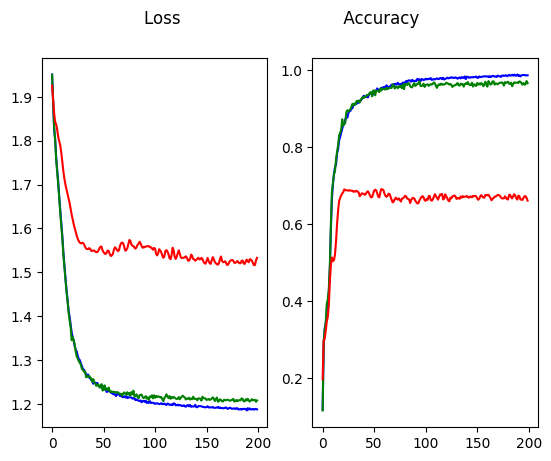

In [29]:
model_gcn1 = GCN_1(num_features=num_features, hidden_channels=64, num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gcn1 = model_gcn1.to(device)
graph_train_torch = graph_train_torch.to(device)
graph_test_torch = graph_test_torch.to(device)
list_loss_train, list_loss_val, list_loss_test, list_train_acc, list_val_acc, list_test_acc = train(
    model_gcn1,
    graph_train_torch,
    graph_test_torch,
    200
)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Loss                               Accuracy')
ax1.plot(list_loss_train, color='blue')
ax1.plot(list_loss_val, color='green')
ax1.plot(list_loss_test, color='red')
ax2.plot(list_train_acc, color='blue')
ax2.plot(list_val_acc, color='green')
ax2.plot(list_test_acc, color='red')

In [30]:
class GCN_2(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN_2, self).__init__()

        # Initialize the layers
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.out = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # First Message Passing Layer
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        
        # # Third Message Passing Layer
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Output layer + softmax
        x = self.out(x)
        x = F.softmax(x, dim=1)
        return x

[codecarbon INFO @ 15:35:18] [setup] RAM Tracking...
[codecarbon INFO @ 15:35:18] [setup] GPU Tracking...
[codecarbon INFO @ 15:35:18] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 15:35:18] [setup] CPU Tracking...
[codecarbon WARNING @ 15:35:18] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 15:35:19] We saw that you have a Intel(R) Core(TM) i5-14600KF but we don't know it. Please contact us.
[codecarbon INFO @ 15:35:19] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-14600KF
[codecarbon INFO @ 15:35:19] >>> Tracker's metadata:
[codecarbon INFO @ 15:35:19]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 15:35:19]   Python version: 3.10.11
[codecarbon INFO @ 15:35:19]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 15:35:19]   Available RAM : 31.852 GB
[codecarbon INFO @ 15:35:19]   CPU count: 20
[codecarbon INFO @ 15:35:19]   CPU model: Intel(R) Core(TM) i5-14600KF
[codecarbon INFO @ 15:35:19]   GPU count: 1
[codeca

Epoch 0 | Loss Train : 1.9478 | Loss Val : 1.9487 | Loss Test : 1.9432 | Train Accuracy : 0.1464 | Val Accuracy : 0.1303 | Test Accuracy: 0.1467
Epoch 1 | Loss Train : 1.9385 | Loss Val : 1.9388 | Loss Test : 1.9319 | Train Accuracy : 0.1844 | Val Accuracy : 0.1882 | Test Accuracy: 0.2408
Epoch 2 | Loss Train : 1.9089 | Loss Val : 1.9081 | Loss Test : 1.9144 | Train Accuracy : 0.2370 | Val Accuracy : 0.2403 | Test Accuracy: 0.1908
Epoch 3 | Loss Train : 1.9091 | Loss Val : 1.9101 | Loss Test : 1.9037 | Train Accuracy : 0.2122 | Val Accuracy : 0.2143 | Test Accuracy: 0.1899
Epoch 4 | Loss Train : 1.8695 | Loss Val : 1.8686 | Loss Test : 1.8952 | Train Accuracy : 0.2638 | Val Accuracy : 0.2723 | Test Accuracy: 0.1913
Epoch 5 | Loss Train : 1.8985 | Loss Val : 1.8897 | Loss Test : 1.8918 | Train Accuracy : 0.2414 | Val Accuracy : 0.2504 | Test Accuracy: 0.2471
Epoch 6 | Loss Train : 1.8967 | Loss Val : 1.8944 | Loss Test : 1.8596 | Train Accuracy : 0.2414 | Val Accuracy : 0.2496 | Test Ac

[codecarbon INFO @ 15:35:22] 
Graceful stopping: collecting and writing information.
Please wait a few seconds...
[codecarbon INFO @ 15:35:22] Energy consumed for RAM : 0.000009 kWh. RAM Power : 11.944398880004883 W
[codecarbon INFO @ 15:35:22] Energy consumed for all GPUs : 0.000030 kWh. Total GPU Power : 40.20300908247448 W
[codecarbon INFO @ 15:35:22] Energy consumed for all CPUs : 0.000032 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:35:22] 0.000070 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:35:22] Done!



Epoch 376 | Loss Train : 1.1815 | Loss Val : 1.1871 | Loss Test : 1.4144 | Train Accuracy : 0.9873 | Val Accuracy : 0.9824 | Test Accuracy: 0.7471
Epoch 377 | Loss Train : 1.1833 | Loss Val : 1.1820 | Loss Test : 1.4365 | Train Accuracy : 0.9847 | Val Accuracy : 0.9866 | Test Accuracy: 0.7277
Epoch 378 | Loss Train : 1.1817 | Loss Val : 1.1857 | Loss Test : 1.4480 | Train Accuracy : 0.9873 | Val Accuracy : 0.9815 | Test Accuracy: 0.7151
Epoch 379 | Loss Train : 1.1832 | Loss Val : 1.1824 | Loss Test : 1.4386 | Train Accuracy : 0.9852 | Val Accuracy : 0.9866 | Test Accuracy: 0.7232
Epoch 380 | Loss Train : 1.1893 | Loss Val : 1.1854 | Loss Test : 1.4040 | Train Accuracy : 0.9789 | Val Accuracy : 0.9832 | Test Accuracy: 0.7633
Epoch 381 | Loss Train : 1.1811 | Loss Val : 1.1823 | Loss Test : 1.3738 | Train Accuracy : 0.9886 | Val Accuracy : 0.9874 | Test Accuracy: 0.8033
Epoch 382 | Loss Train : 1.1849 | Loss Val : 1.1838 | Loss Test : 1.3611 | Train Accuracy : 0.9847 | Val Accuracy : 0.

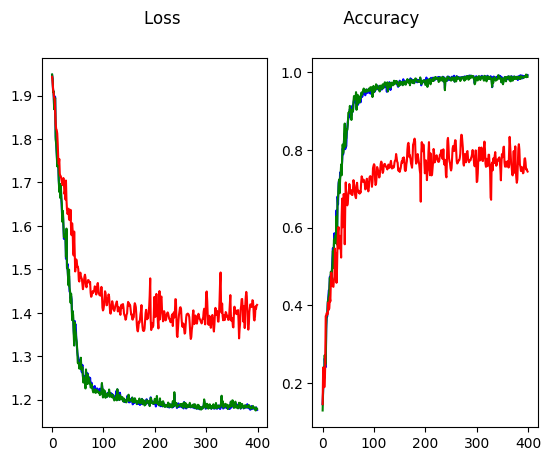

In [31]:
model_gcn2 = GCN_2(num_features=num_features, hidden_channels=64, num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gcn2 = model_gcn2.to(device)
graph_train_torch = graph_train_torch.to(device)
graph_test_torch = graph_test_torch.to(device)
list_loss_train, list_loss_val, list_loss_test, list_train_acc, list_val_acc, list_test_acc = train(
    model_gcn2,
    graph_train_torch,
    graph_test_torch,
    400
)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Loss                               Accuracy')
ax1.plot(list_loss_train, color='blue')
ax1.plot(list_loss_val, color='green')
ax1.plot(list_loss_test, color='red')
ax2.plot(list_train_acc, color='blue')
ax2.plot(list_val_acc, color='green')
ax2.plot(list_test_acc, color='red')

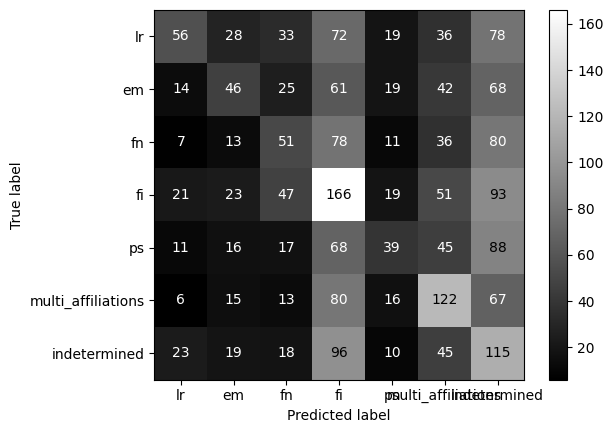

In [15]:
with torch.no_grad():
    model_fcnn.eval()
    y_true = torch.argmax(graph_test_torch.labels, dim=1).cpu().numpy()
    y_pred = torch.argmax(model_fcnn(graph_test_torch.features), dim=1).cpu().numpy()
    mat = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=mat, display_labels=['lr','em','fn','fi','ps','multi_affiliations','indetermined']).plot(cmap='gray')

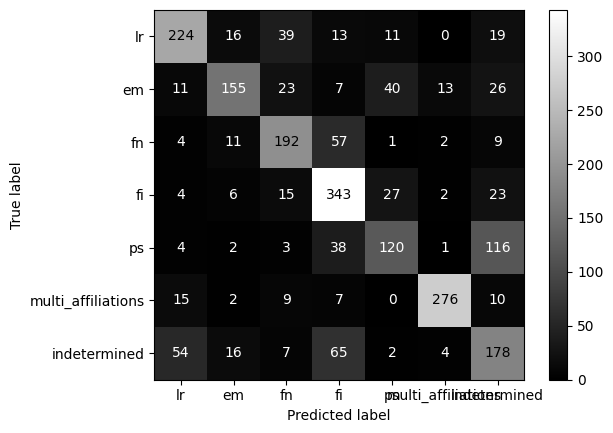

In [16]:
with torch.no_grad():
    model_gcn1.eval()
    y_true = torch.argmax(graph_test_torch.labels, dim=1).cpu().numpy()
    y_pred = torch.argmax(model_gcn1(graph_test_torch.features, graph_test_torch.edge_index), dim=1).cpu().numpy()
    mat = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=mat, display_labels=['lr','em','fn','fi','ps','multi_affiliations','indetermined']).plot(cmap='gray')

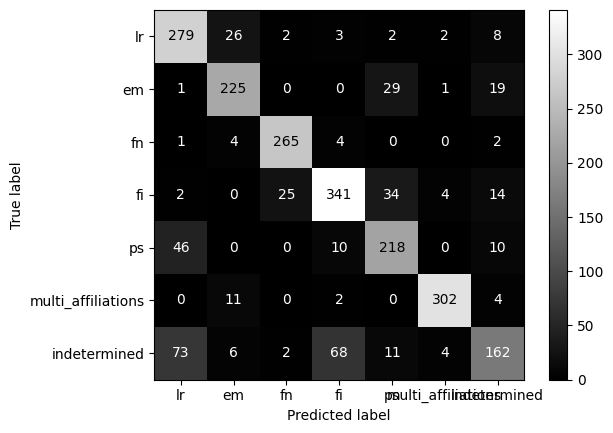

In [17]:
with torch.no_grad():
    model_gcn2.eval()
    y_true = torch.argmax(graph_test_torch.labels, dim=1).cpu().numpy()
    y_pred = torch.argmax(model_gcn2(graph_test_torch.features, graph_test_torch.edge_index), dim=1).cpu().numpy()
    mat = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=mat, display_labels=['lr','em','fn','fi','ps','multi_affiliations','indetermined']).plot(cmap='gray')

[0.8064806461334229, 0.07155715674161911, 0.027452746406197548, 0.029252925887703896, 0.01845184527337551, 0.018001800402998924, 0.02880288101732731]


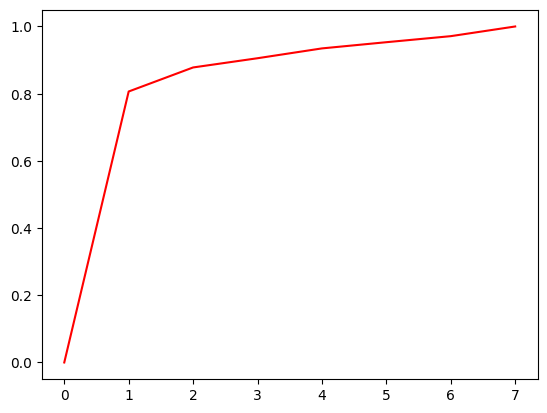

In [18]:
with torch.no_grad():
    model_gcn2.eval()
    logits_test = model_gcn2(graph_test_torch.features, graph_test_torch.edge_index)
    logits_test = torch.argsort(logits_test, dim=1)
    true_labels = torch.argmax(graph_test_torch.labels, dim=1)
    list_test_acc = []
    for i in range(7):
        list_test_acc.append(
            float((logits_test[:,i] == true_labels).float().mean())
        )
    list_test_acc = list_test_acc[::-1]
    print(list_test_acc)
    # plt.plot(list_test_acc, color='blue')
    list_test_acc_cumul = [0.0] + [sum(list_test_acc[:i]) for i in range(1,8)]
    plt.plot(list_test_acc_cumul, color='red')

In [33]:
# save the predictions for each models

with torch.no_grad():
    model_fcnn.eval()
    model_gcn1.eval()
    model_gcn2.eval()
    train_y_true = np.argmax(graph_train_torch.labels.cpu().numpy(), axis=1)
    out = model_fcnn(graph_train_torch.features)
    train_y_pred_fcnn = np.argmax(out.cpu().numpy(), axis=1)
    out = model_gcn1(graph_train_torch.features, graph_train_torch.edge_index)
    train_y_pred_gcn1 = np.argmax(out.cpu().numpy(), axis=1)
    out = model_gcn2(graph_train_torch.features, graph_train_torch.edge_index)
    train_y_pred_gcn2 = np.argmax(out.cpu().numpy(), axis=1)

    test_y_true = np.argmax(graph_test_torch.labels.cpu().numpy(), axis=1)
    out = model_fcnn(graph_test_torch.features)
    test_y_pred_fcnn = np.argmax(out.cpu().numpy(), axis=1)
    out = model_gcn1(graph_test_torch.features, graph_test_torch.edge_index)
    test_y_pred_gcn1 = np.argmax(out.cpu().numpy(), axis=1)
    out = model_gcn2(graph_test_torch.features, graph_test_torch.edge_index)
    test_y_pred_gcn2 = np.argmax(out.cpu().numpy(), axis=1)
    

    # with open('predictions/elyzee.json', 'w') as f:
    #     json.dump({
    #         'train': [{
    #             'y_true': int(a),
    #             'y_pred_fcnn': int(b),
    #             'y_pred_gcn1': int(c),
    #             'y_pred_gcn2': int(d)
    #         } for a,b,c,d in zip(train_y_true, train_y_pred_fcnn, train_y_pred_gcn1, train_y_pred_gcn2)],
    #         'test': [{
    #              'y_true': int(a),
    #             'y_pred_fcnn': int(b),
    #             'y_pred_gcn1': int(c),
    #             'y_pred_gcn2': int(d)
    #         } for a,b,c,d in zip(test_y_true, test_y_pred_fcnn, test_y_pred_gcn1, test_y_pred_gcn2)]
    #     }, f)